In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
path = '/content/gdrive/MyDrive/Dataset/CJ AI/'

In [4]:
march = pd.read_csv(path + 'march.csv', encoding = 'utf-8')
april = pd.read_csv(path + 'april.csv', encoding = 'utf-8')
may = pd.read_csv(path + 'may.csv', encoding = 'utf-8')
june = pd.read_csv(path + 'june.csv', encoding = 'utf-8')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df = pd.concat((march, april, may, june), axis = 0)

In [6]:
columns = ['CORP_ID', 'BKG_DATE', 'SHPR_CD', 'ITEM_SEQ', 'ITEM_CD', 'ITEM_QTY', 'ITEM_AMT', 
           'BRAND_NM', 'POST_ZONE']
           # , 'SHPR_ADDR1', 'SHPR_ADDR1', 'CNEE_ADDR1', 'CNEE_ADDR1'
dataset = df[columns]
dataset = df.groupby(columns,as_index=False).sum()
dataset = dataset[columns]
dataset = dataset.dropna(axis = 0, how = 'any')

In [7]:
category_columns = ['SHPR_CD', 'BRAND_NM', 'CORP_ID', 'ITEM_CD']
for i in category_columns:
  L_encoder = LabelEncoder()
  L_encoder.fit(dataset[i].astype(str))
  dataset[i] = L_encoder.transform(dataset[i].astype(str))

In [8]:
dataset['ITEM_AMT'] = np.sqrt(dataset['ITEM_AMT'])

In [9]:
# dataset['year'] = dataset['BKG_DATE'].astype(str).str[0:4].astype(int)
dataset['month'] = dataset['BKG_DATE'].astype(str).str[4:6].astype(int)
dataset['day'] = dataset['BKG_DATE'].astype(str).str[6:].astype(int)

In [10]:
dataset = dataset.drop(columns = 'BKG_DATE')
Y_total = dataset['ITEM_QTY']
Y_total = Y_total.astype('float64')

In [11]:
X_total = dataset.drop(columns = 'ITEM_QTY')

In [12]:
# 데이터 분리. train - 0.64, valid - 0.16, test_public = 0.1, test_private = 0.1
X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.2, random_state=123)
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=123)
X_test_public, X_test_private, Y_test_public, Y_test_private = train_test_split(X_test, Y_test, test_size=0.5, random_state=123)

# Model part

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,Dot,Add,Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD,Adamax
from tensorflow.keras.layers import Dense,Concatenate,BatchNormalization,LayerNormalization, Dropout
from keras import backend as K

In [14]:
def RMSE(y_true,y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_pred,y_true))))

In [21]:
# Index(['CORP_ID', 'SHPR_CD', 'ITEM_SEQ', 'ITEM_CD', 'ITEM_AMT', 'BRAND_NM',
#        'POST_ZONE', 'month', 'day'])

C = dataset.CORP_ID.max()+1
S = dataset.SHPR_CD.max()+1
IS = dataset.ITEM_SEQ.max()+1
I = dataset.ITEM_CD.max()+1
IA = int(dataset.ITEM_AMT.max())+1
BN = int(dataset.BRAND_NM.max()) + 1
P = int(dataset.POST_ZONE.max())+1
M = dataset.month.max()+1
D = dataset.day.max()+1

In [91]:
def Unet_MLP_ver1():
    corp = Input(shape = (1,))
    brand = Input(shape = (1,))
    itemcd = Input(shape=(1,))
    shpr = Input(shape=(1,))
    post = Input(shape=(1,))
    itemseq = Input(shape=(1,))
    itemamt = Input(shape=(1,))
    month = Input(shape=(1,))
    day = Input(shape=(1,))

    K = 150

    C_embedding = Embedding(C,K,embeddings_regularizer=l2())(corp)
    BN_embedding = Embedding(BN,K,embeddings_regularizer=l2())(brand)
    I_embedding = Embedding(I,K,embeddings_regularizer=l2())(itemcd)
    S_embedding = Embedding(S,K,embeddings_regularizer=l2())(shpr)
    P_embedding = Embedding(P,K,embeddings_regularizer=l2())(post)
    IS_embedding = Embedding(IS,K,embeddings_regularizer=l2())(itemseq)
    IA_embedding = Embedding(IA,K,embeddings_regularizer=l2())(itemamt) 
    M_embedding = Embedding(M,K,embeddings_regularizer=l2())(month)
    D_embedding = Embedding(D,K,embeddings_regularizer=l2())(day)



    #아래 부분은 경향성 부분인데, 아직 안보이니 pass

    IA_bias = Embedding(IA,1,embeddings_regularizer=l2())(itemamt)
    IS_bias = Embedding(IS,1,embeddings_regularizer=l2())(itemseq)

    #user_bias = Embedding(U.max()+1,1,embeddings_regularizer=l2())(user) #user를 특정 할 수 있는 정보가 있을 때 사용
    #sex_bias = Embedding(S,1,embeddings_regularizer=l2())(sex)
    #age_bias = Embedding(A,1,embeddings_regularizer=l2())(age)
    #hj_bias = Embedding(H,1,embeddings_regularizer=l2())(hj)
    #item_bias = Embedding(I,1,embeddings_regularizer=l2())(item_buz)

    from tensorflow.keras.layers import Dense,Concatenate,Activation


    C_embedding = Flatten()(C_embedding)
    BN_embedding = Flatten()(BN_embedding)
    I_embedding = Flatten()(I_embedding)
    S_embedding = Flatten()(S_embedding)
    P_embedding = Flatten()(P_embedding)
    IS_embedding = Flatten()(IS_embedding)
    IA_embedding = Flatten()(IA_embedding)
    M_embedding = Flatten()(M_embedding)
    D_embedding = Flatten()(D_embedding)

    IA_bias = Flatten()(IA_bias)
    IS_bias = Flatten()(IS_bias)
    #user_bias = Flatten()(user_bias)
    #sex_bias = Flatten()(sex_bias)
    #age_bias = Flatten()(age_bias)
    #hj_bias = Flatten()(hj_bias)
    #item_bias = Flatten()(item_bias)


    #user_bias 와 U_embedding을 user를 특정 할 수 있는 정보가 있다면 추가하면 좋다. => 더 높은 정확성과, 적은 오류를 가질 것이다.
    R = Concatenate()([C_embedding, BN_embedding, I_embedding, S_embedding, P_embedding, IS_embedding,
                      IA_embedding, M_embedding, D_embedding, IA_bias, IS_bias])

    n_nodes = 256

    UB1 = Dense(n_nodes, activation="relu")(R)
    UB2 = Dense(n_nodes * 2, activation="relu")(UB1)
    UB3 = Dense(n_nodes * 4, activation="relu")(UB2)
    UB4 = Dense(n_nodes * 8, activation="relu")(UB3)
    UB5 = Dense(n_nodes * 16, activation="relu")(UB4)

    DB5 = Dense(n_nodes * 16, activation="relu")(UB5)
    DB5 = Add()([DB5, UB5])
    DB4 = Dense(n_nodes * 8, activation="relu")(DB5)
    DB4 = Add()([DB4, UB4])
    DB3 = Dense(n_nodes * 4, activation="relu")(DB4)
    DB3 = Add()([DB3, UB3])
    DB2 = Dense(n_nodes * 2, activation="relu")(DB3)
    DB2 = Add()([DB2, UB2])
    DB1 = Dense(n_nodes * 1, activation="relu")(DB2)
    DB1 = Add()([DB1, UB1])

    outputs = Dense(1, activation="linear")(DB1)
    model = Model(inputs=[corp, brand, itemcd,shpr,post,itemseq,itemamt,month,day],outputs= outputs)
    return model
model_ver1 = Unet_MLP_ver1()
model_ver1.compile(
    loss = RMSE,
    optimizer = 'Adam',
    metrics = [RMSE]
)

model_ver1.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_93 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_94 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_95 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_96 (InputLayer)           [(None, 1)]          0                                            
___________________________________________________________________________________________

In [123]:
def Unet_MLP_ver2():
    corp = Input(shape = (1,))
    brand = Input(shape = (1,))
    itemcd = Input(shape=(1,))
    shpr = Input(shape=(1,))
    post = Input(shape=(1,))
    itemseq = Input(shape=(1,))
    itemamt = Input(shape=(1,))
    month = Input(shape=(1,))
    day = Input(shape=(1,))

    K = 150

    C_embedding = Embedding(C,K,embeddings_regularizer=l2())(corp)
    BN_embedding = Embedding(BN,K,embeddings_regularizer=l2())(brand)
    I_embedding = Embedding(I,K,embeddings_regularizer=l2())(itemcd)
    S_embedding = Embedding(S,K,embeddings_regularizer=l2())(shpr)
    P_embedding = Embedding(P,K,embeddings_regularizer=l2())(post)
    IS_embedding = Embedding(IS,K,embeddings_regularizer=l2())(itemseq)
    IA_embedding = Embedding(IA,K,embeddings_regularizer=l2())(itemamt) 
    M_embedding = Embedding(M,K,embeddings_regularizer=l2())(month)
    D_embedding = Embedding(D,K,embeddings_regularizer=l2())(day)



    #아래 부분은 경향성 부분인데, 아직 안보이니 pass

    IA_bias = Embedding(IA,1,embeddings_regularizer=l2())(itemamt)
    IS_bias = Embedding(IS,1,embeddings_regularizer=l2())(itemseq)

    #user_bias = Embedding(U.max()+1,1,embeddings_regularizer=l2())(user) #user를 특정 할 수 있는 정보가 있을 때 사용
    #sex_bias = Embedding(S,1,embeddings_regularizer=l2())(sex)
    #age_bias = Embedding(A,1,embeddings_regularizer=l2())(age)
    #hj_bias = Embedding(H,1,embeddings_regularizer=l2())(hj)
    #item_bias = Embedding(I,1,embeddings_regularizer=l2())(item_buz)



    C_embedding = Flatten()(C_embedding)
    BN_embedding = Flatten()(BN_embedding)
    I_embedding = Flatten()(I_embedding)
    S_embedding = Flatten()(S_embedding)
    P_embedding = Flatten()(P_embedding)
    IS_embedding = Flatten()(IS_embedding)
    IA_embedding = Flatten()(IA_embedding)
    M_embedding = Flatten()(M_embedding)
    D_embedding = Flatten()(D_embedding)

    IA_bias = Flatten()(IA_bias)
    IS_bias = Flatten()(IS_bias)
    #user_bias = Flatten()(user_bias)
    #sex_bias = Flatten()(sex_bias)
    #age_bias = Flatten()(age_bias)
    #hj_bias = Flatten()(hj_bias)
    #item_bias = Flatten()(item_bias)


    #user_bias 와 U_embedding을 user를 특정 할 수 있는 정보가 있다면 추가하면 좋다. => 더 높은 정확성과, 적은 오류를 가질 것이다.
    R = Concatenate()([C_embedding, BN_embedding, I_embedding, S_embedding, P_embedding, IS_embedding,
                      IA_embedding, M_embedding, D_embedding, IA_bias, IS_bias])

    n_nodes = 128
    drop_rate = 0.05
    def up_block(input, n_nodes = 128):
      block = Dense(n_nodes, activation="relu")(input)
      block = BatchNormalization(axis=1)(block)
      return block
    def down_block(input, connect_block, n_nodes = 256, drop_rate = drop_rate):
      # block = LayerNormalization()(input)
      block = Dense(n_nodes, activation="relu")(input)
      block = BatchNormalization(axis=1)(block)
      block = Add()([block, connect_block])
      block = Dropout(drop_rate)(block)
      return block


    UB1 = up_block(R, n_nodes)
    UB2 = up_block(UB1, n_nodes * 2)
    UB3 = up_block(UB2, n_nodes * 4)
    UB4 = up_block(UB3, n_nodes * 8)
    UB5 = up_block(UB4, n_nodes * 16)
    UB6 = up_block(UB5, n_nodes * 32)
    UB7 = up_block(UB6, n_nodes * 64)

    DB6 = down_block(UB7, UB6, n_nodes * 32)
    DB5 = down_block(DB6, UB5, n_nodes * 16)
    DB4 = down_block(DB5, UB4, n_nodes * 8)
    DB3 = down_block(DB4, UB3, n_nodes * 4)
    DB2 = down_block(DB3, UB2, n_nodes * 2)
    DB1 = down_block(DB2, UB1, n_nodes)

    outputs = Dense(1, activation="linear")(DB1)
    model = Model(inputs=[corp, brand, itemcd,shpr,post,itemseq,itemamt,month,day],outputs= outputs)
    return model

model_ver2 = Embedding_Unet_MLP()
model_ver2.compile(
    loss = RMSE,
    optimizer = 'Adam',
    metrics = [RMSE]
)

model_ver2.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_120 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_121 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_122 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_123 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

In [ ]:
# [X_valid.CORP_ID. X_valid.BRAMD_NM, X_valid.ITEM_CD, X_valid.SHPR_CD, X_valid.POST_ZONE, X_valid.ITEM_SEQ, X_valid.ITEM_AMT, X_valid.month, X_valid.day]

In [126]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = '/content/gdrive/MyDrive/Dataset/CJ AI/layer_7_n_nodes_128_lossF_rmse_batchrnorm_drop_rate_0.05_9features.h5',
        monitor = 'val_loss',
        save_best_only=True
    )]

In [127]:
model_ver2.fit(x = (X_train.CORP_ID, X_train.BRAND_NM, X_train.ITEM_CD,X_train.SHPR_CD,X_train.POST_ZONE,X_train.ITEM_SEQ,X_train.ITEM_AMT,X_train.month,X_train.day),
          y = Y_train,
          validation_split = 0.2,
          batch_size = 10000,
          shuffle = True,
          epochs = 100,
          callbacks = callbacks_list)

Epoch 1/100
85/85 [==============================] - 40s 470ms/step - loss: 4.5861 - RMSE: 1.9555 - val_loss: 2.0077 - val_RMSE: 1.8229


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
85/85 [==============================] - 40s 465ms/step - loss: 1.6965 - RMSE: 1.4866 - val_loss: 2.0937 - val_RMSE: 1.9100
Epoch 3/100
85/85 [==============================] - 40s 465ms/step - loss: 1.4260 - RMSE: 1.2109 - val_loss: 2.2453 - val_RMSE: 2.0569
Epoch 4/100
85/85 [==============================] - 40s 466ms/step - loss: 1.3636 - RMSE: 1.1511 - val_loss: 2.0517 - val_RMSE: 1.8691
Epoch 5/100
85/85 [==============================] - 40s 465ms/step - loss: 1.2537 - RMSE: 1.0409 - val_loss: 2.1823 - val_RMSE: 1.9933
Epoch 6/100
85/85 [==============================] - 40s 465ms/step - loss: 1.1910 - RMSE: 0.9769 - val_loss: 1.8676 - val_RMSE: 1.6830
Epoch 7/100
85/85 [==============================] - 39s 465ms/step - loss: 1.1101 - RMSE: 0.8998 - val_loss: 1.7052 - val_RMSE: 1.5069
Epoch 8/100
85/85 [==============================] - 39s 465ms/step - loss: 1.0229 - RMSE: 0.8095 - val_loss: 1.3593 - val_RMSE: 1.1621
Epoch 9/100
85/85 [=============================

KeyboardInterrupt: ignored

loss - mae, metrics = mape

 val_RMSE: 0.4420

# Model Evaluation

In [137]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Dataset/CJ AI/rmse_9features.h5', 
                                   custom_objects = {'RMSE': RMSE})

In [138]:
predict_public = model.predict(x = [X_test_public.CORP_ID, X_test_public.BRAND_NM, X_test_public.ITEM_CD,
                                    X_test_public.SHPR_CD, X_test_public.POST_ZONE, X_test_public.ITEM_SEQ,
                                    X_test_public.ITEM_AMT, X_test_public.month, X_test_public.day])

In [139]:
predict_private = model.predict(x = [X_test_private.CORP_ID, X_test_private.BRAND_NM, X_test_private.ITEM_CD,
                                    X_test_private.SHPR_CD, X_test_private.POST_ZONE, X_test_private.ITEM_SEQ,
                                    X_test_private.ITEM_AMT, X_test_private.month, X_test_private.day])

In [140]:
predict_public = pd.DataFrame(predict_public)
predict_private = pd.DataFrame(predict_private)

In [141]:
predict_public = round(predict_public)
predict_private = round(predict_private)

In [142]:
Y_test_public = Y_test_public.reset_index(drop=True)
Y_test_public = pd.DataFrame(Y_test_public)
Y_test_private = Y_test_private.reset_index(drop=True)
Y_test_private = pd.DataFrame(Y_test_private)

In [134]:
new_public_test = pd.concat((predict_public, Y_test_public), axis = 1, ignore_index = True, join='inner')
new_private_test = pd.concat((predict_private, Y_test_private), axis = 1, ignore_index = True, join='inner')

In [143]:
new_public = pd.concat((predict_public, Y_test_public), axis = 1, ignore_index = True, join='inner')
new_private = pd.concat((predict_private, Y_test_private), axis = 1, ignore_index = True, join='inner')

In [136]:
print(len(new_public_test[new_public_test[0] == new_public_test[1]]) / len(new_public_test[0]))
print(len(new_private_test[new_private_test[0] == new_private_test[1]]) / len(new_private_test[0]))
# test가 새로운 버전

0.9722067438743393
0.9712052529329378


In [144]:
print(len(new_public[new_public[0] == new_public[1]]) / len(new_public[0]))
print(len(new_private[new_private[0] == new_private[1]]) / len(new_private[0]))
# 기존 버전

0.9668980888842036
0.9668604388488126


In [145]:
public_mix = (new_public + new_public_test) / 2
private_mix = (new_private + new_private_test) / 2

In [146]:
print(len(public_mix[public_mix[0] == public_mix[1]]) / len(public_mix[0]))
print(len(private_mix[private_mix[0] == private_mix[1]]) / len(private_mix[0]))

0.953103115916929
0.9531934760018674


In [74]:
print(np.sqrt(np.mean((new_public[0] - new_public[1]) ** 2)))
print(np.sqrt(np.mean((new_private[0] - new_private[1]) ** 2)))

3.6066277098277877
0.8580129381396472


In [147]:
print(np.sqrt(np.mean((public_mix[0] - public_mix[1]) ** 2)))
print(np.sqrt(np.mean((private_mix[0] - private_mix[1]) ** 2)))

3.5599101811117184
0.795482039284467


In [148]:
print(np.sqrt(np.mean((new_public_test[0] - new_public_test[1]) ** 2)))
print(np.sqrt(np.mean((new_private_test[0] - new_private_test[1]) ** 2)))

3.522693406302442
0.7755672088312048


In [101]:
new_public.iloc[:,1]

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
132797    1.0
132798    2.0
132799    1.0
132800    5.0
132801    1.0
Name: 1, Length: 132802, dtype: float64

In [150]:
print(len(new_public[new_public[0] == new_public[1]]) / len(new_public[0]))
print(len(new_private[new_private[0] == new_private[1]]) / len(new_private[0]))

0.9668980888842036
0.9668604388488126


In [52]:
len(predict_public[predict_public[0] == 1])

110744

no batchnorm and RMSE/RMSE

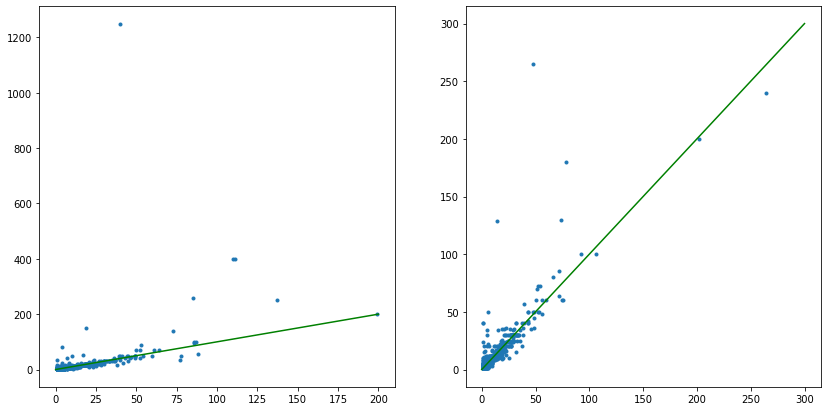

In [156]:
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(new_public.iloc[:,0], new_public.iloc[:,1],'o',markersize=3)
plt.plot([0, 200], [0, 200], color="green")
plt.subplot(1, 2, 2)
plt.plot(new_private.iloc[:,0], new_private.iloc[:,1],'o',markersize=3)
plt.plot([0, 300], [0,300], color="green")

plt.show()

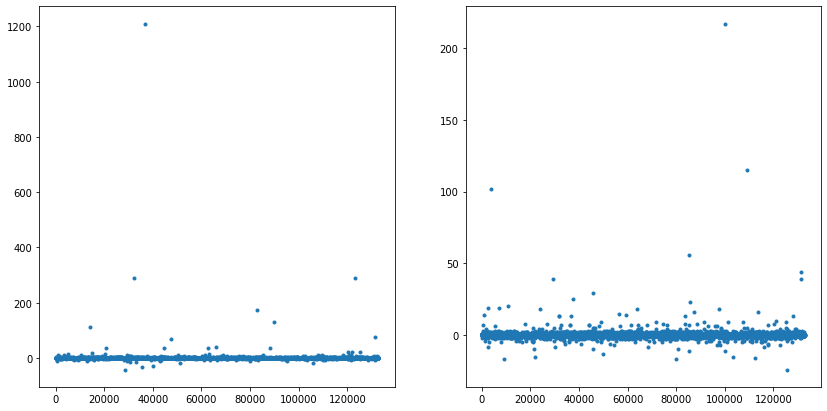

In [159]:
length_public = [i for i in range(len(new_public[0]))]
length_private = [i for i in range(len(new_private[0]))]
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(length_public, new_public.iloc[:,1] - new_public.iloc[:,0],'o',markersize=3)
plt.subplot(1, 2, 2)
plt.plot(length_private, new_private.iloc[:,1] - new_private.iloc[:,0],'o',markersize=3)

plt.show()

In [90]:
print(len(new_public[new_public[0] == new_public[1]]) / len(new_public[0]))
print(len(new_private[new_private[0] == new_private[1]]) / len(new_private[0]))
# 구 모델 정확도

0.9668980888842036
0.9668604388488126


In [176]:
print(len(new_public[(new_public[0] == new_public[1]) & (new_public[1] != 1)]) / len(new_public[1][new_public[1] != 1]))
print(len(new_private[(new_private[0] == new_private[1]) & (new_private[1] != 1)]) / len(new_private[1][new_private[1] != 1]))
# 관찰값(예측값 아님)이 1이 아닌 데이터에서 신 모델 정확도

0.8328231066152003
0.8299700210300237


In [164]:
print(np.sqrt(np.mean((new_public[new_public[1] != 1][0] - new_public[new_public[1] != 1][1]) ** 2)))
print(np.sqrt(np.mean((new_private[new_private[1] != 1][0] - new_private[new_private[1] != 1][1]) ** 2)))
# 구 모델 예측값중 관찰값(예측값 아님)이 1이 아닌 데이터의 RMSE

8.752666241432385
2.0825291898910807


In [171]:
print(np.sqrt(np.mean((new_public[0] - new_public[1]) ** 2)))
print(np.sqrt(np.mean((new_private[0] - new_private[1]) ** 2)))
# 구 모델 전체 데이터 RMSE

3.6066277098277877
0.8580129381396472


RMSE / RMSE, 128 node, 7layers, no dropout, batchborm 적용 (layernorm X)

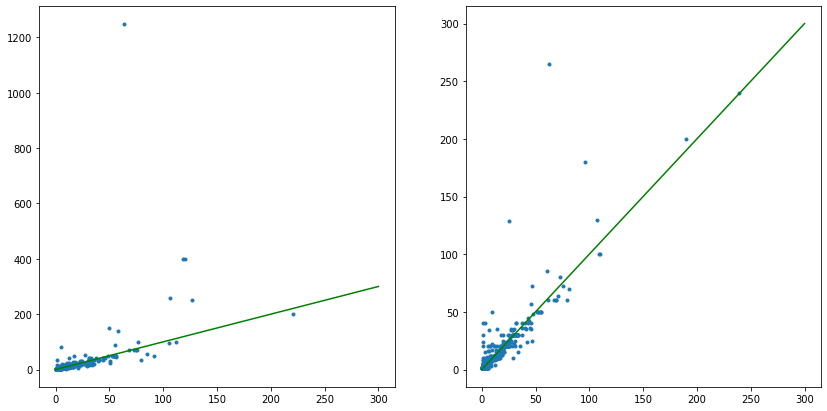

In [161]:
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(new_public_test.iloc[:,0], new_public_test.iloc[:,1],'o',markersize=3)
plt.plot([0, 300], [0, 300], color="green")
plt.subplot(1, 2, 2)
plt.plot(new_private_test.iloc[:,0], new_private_test.iloc[:,1],'o',markersize=3)
plt.plot([0, 300], [0,300], color="green")

plt.show()

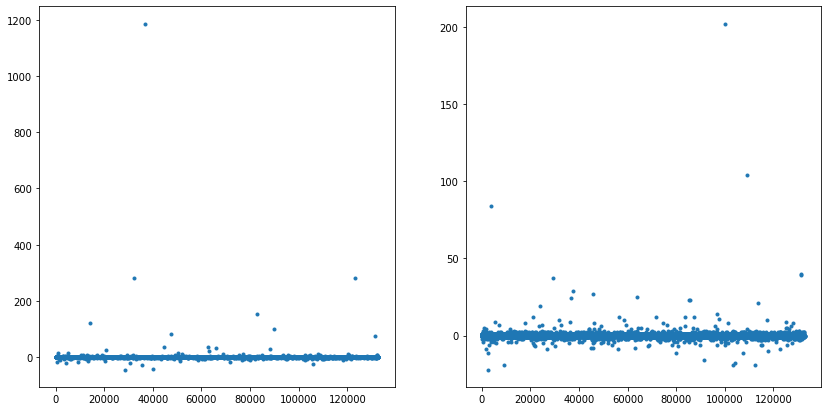

In [163]:
length_public = [i for i in range(len(new_public[0]))]
length_private = [i for i in range(len(new_private[0]))]
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(length_public, new_public_test.iloc[:,1] - new_public_test.iloc[:,0],'o',markersize=3)
plt.subplot(1, 2, 2)
plt.plot(length_private, new_private_test.iloc[:,1] - new_private_test.iloc[:,0],'o',markersize=3)

plt.show()

In [166]:
print(np.sqrt(np.mean((new_public_test[new_public_test[1] != 1][0] - new_public_test[new_public_test[1] != 1][1]) ** 2)))
print(np.sqrt(np.mean((new_private_test[new_private_test[1] != 1][0] - new_private_test[new_private_test[1] != 1][1]) ** 2)))
# 신 모델 예측값중 관찰값(예측값 아님)이 1이 아닌 데이터의 RMSE

8.549649080578583
1.8831710408959985


In [169]:
print(np.sqrt(np.mean((new_public_test[0] - new_public_test[1]) ** 2)))
print(np.sqrt(np.mean((new_private_test[0] - new_private_test[1]) ** 2)))
# 전체 데이터 RMSE

3.522693406302442
0.7755672088312048


In [177]:
print(len(new_public_test[new_public_test[0] == new_public_test[1]]) / len(new_public_test[0]))
print(len(new_private_test[new_private_test[0] == new_private_test[1]]) / len(new_private_test[0]))
# 신 모델 정확도

0.9722067438743393
0.9712052529329378


In [175]:
print(len(new_public_test[(new_public_test[0] == new_public_test[1]) & (new_public_test[1] != 1)]) / len(new_public_test[1][new_public_test[1] != 1]))
print(len(new_private_test[(new_private_test[0] == new_private_test[1]) & (new_private_test[1] != 1)]) / len(new_private_test[1][new_private_test[1] != 1]))
# 관찰값(예측값 아님)이 1이 아닌 데이터에서 신 모델 정확도

0.8530990727183992
0.847107253120945
